In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import argparse

import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from models import ConvolutionalBiAAE

%matplotlib inline
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.set_grad_enabled(False)

def clear_pane():
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

def load_model(path, device='cpu'):
    state_dict = torch.load(path)
    args = argparse.Namespace(**state_dict['model_arguments'])
    model = ConvolutionalBiAAE(args)
    for name, submodel in model.submodels.items():
        submodel.load_state_dict(state_dict[name])
        submodel.to(device)
        submodel.eval()
    return model

In [2]:
device = 'cpu' # Change it to cuda:0 if you're using GPU 0

In [3]:
data = np.load('data/noisy_mnist.npz')
x, y, digits = data['test'][0].astype('float32'), data['test'][1].astype('float32'), data['test_digit'].astype('int')

### Test Data: the first row comes from $X$, the second row is the corresponding condition from $Y$

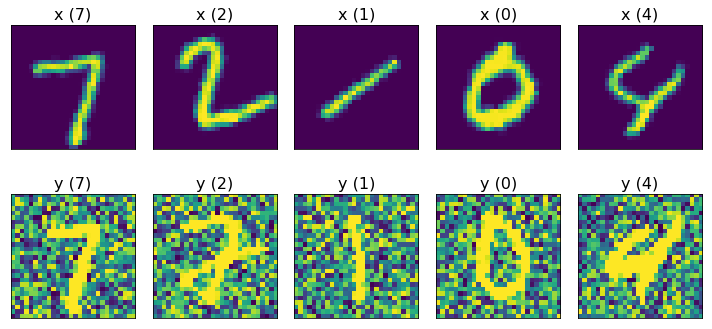

In [4]:
plt.figure(figsize=(10,5))
some_indices = np.arange(5)
for i in range(len(some_indices)):
    plt.subplot(2, len(some_indices), i+1)
    plt.imshow(x[i].reshape(28, 28).T)
    plt.title(f'x ({digits[i]})', fontsize=16)
    clear_pane()
for i in range(len(some_indices)):
    plt.subplot(2, len(some_indices), i+1+len(some_indices))
    plt.imshow(y[i].reshape(28, 28).T)
    plt.title(f'y ({digits[i]})', fontsize=16)
    clear_pane()
plt.tight_layout()

## Generation

In [5]:
digits

array([7, 2, 1, ..., 4, 5, 6])

In [6]:
n = 5  # sampled conditions
m = 10  # generate per sample
sampled_indices = list(range(n))#np.random.randint(x.shape[0], size=n)

In [7]:
def plot_grid(condition, generated, digits):
    plt.figure(figsize=(10, int(1.5*condition.shape[0])))
    for j in range(n):
        plt.subplot(n, m+1, (m+1)*j + 1)
        plt.title(f'Condition\'s digit: {digits[j]}')
        plt.imshow(condition[j].reshape(28, 28).T)
        clear_pane()
        for i in range(m):
            plt.subplot(n, m+1, i+2+(m+1)*j)
            plt.imshow(generated[i][j].reshape(28, 28).T)
            clear_pane()

### Generate $x$ from $y$ with BiAAE

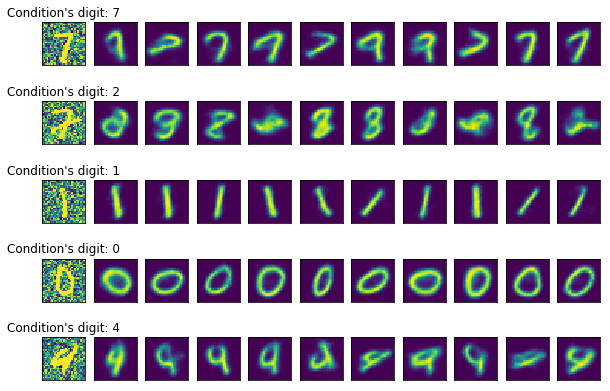

In [8]:
model = load_model('models/BiAAE_renamed/model.tar', device=device)
condition_y = torch.from_numpy(y[sampled_indices].reshape(-1, 1, 28, 28)).to(device)
generated_x = [model.generate(condition_y).cpu().numpy() for _ in range(m)]
plot_grid(y[sampled_indices], generated_x, digits[sampled_indices])

### Generate $x$ from $y$ with UniAAE

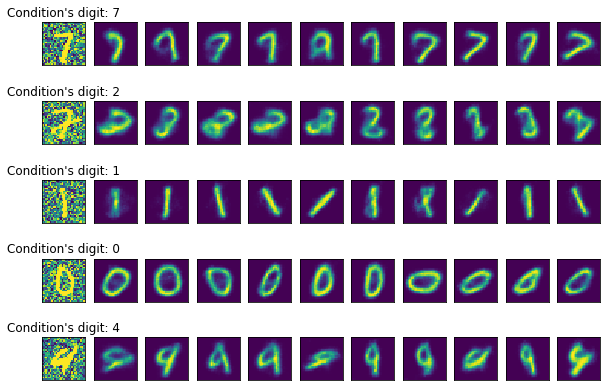

In [9]:
model = load_model('models/UniAAE/model.tar', device=device)
condition_y = torch.from_numpy(y[sampled_indices].reshape(-1, 1, 28, 28)).to(device)
generated_x = [model.generate(condition_y).cpu().numpy() for _ in range(m)]
plot_grid(y[sampled_indices], generated_x, digits[sampled_indices])